# Test if RegVelo is sensitive to prior GRN structure

## Library imports

In [1]:
import math
import os
import random
from typing import Literal

2024-08-10 00:09:26.956391: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-10 00:09:29.119826: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-10 00:09:29.120253: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-10 00:09:29.133114: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-10 00:09:30.292422: I tensorflow/core/platform/cpu_feature_g

In [ ]:
from paths import DATA_DIR, FIG_DIR
from regvelo import REGVELOVI

import numpy as np
import pandas as pd
import scipy
import sklearn
from scipy.stats import ttest_ind

import mplscience
import seaborn as sns
from matplotlib import pyplot as plt

import anndata
import scanpy as sc
import scvelo as scv
import torch
from velovi import preprocess_data, VELOVI

## General settings

In [2]:
plt.rcParams["svg.fonttype"] = "none"

sns.reset_defaults()
sns.reset_orig()
scv.settings.set_figure_params("scvelo", dpi_save=400, dpi=80, transparent=True, fontsize=14, color_map="viridis")

In [3]:
SAVE_FIGURES = True
if SAVE_FIGURES:
    os.makedirs(FIG_DIR / "simulation" / "prior_benchmark", exist_ok=True)

SAVE_DATASETS = True
if SAVE_DATASETS:
    os.makedirs(DATA_DIR / "simulation" / "prior_benchmark", exist_ok=True)

## Function defination

In [4]:
def get_significance(pvalue):
    """TODO."""
    if pvalue < 0.001:
        return "***"
    elif pvalue < 0.01:
        return "**"
    elif pvalue < 0.1:
        return "*"
    else:
        return "n.s."


def add_significance(ax, left: int, right: int, significance: str, level: int = 0, **kwargs):
    """TODO."""
    bracket_level = kwargs.pop("bracket_level", 1)
    bracket_height = kwargs.pop("bracket_height", 0.02)
    text_height = kwargs.pop("text_height", 0.01)

    bottom, top = ax.get_ylim()
    y_axis_range = top - bottom

    bracket_level = (y_axis_range * 0.07 * level) + top * bracket_level
    bracket_height = bracket_level - (y_axis_range * bracket_height)

    ax.plot([left, left, right, right], [bracket_height, bracket_level, bracket_level, bracket_height], **kwargs)

    ax.text(
        (left + right) * 0.5,
        bracket_level + (y_axis_range * text_height),
        significance,
        ha="center",
        va="bottom",
        c="k",
    )


def csgn_groundtruth(adata):
    """TODO."""
    csgn_array = adata.obsm["regulatory_network_sc"].toarray()
    csgn_tensor = torch.zeros([len(adata.uns["regulators"]), len(adata.uns["targets"]), csgn_array.shape[0]])

    for k in range(csgn_array.shape[0]):
        ## generate a 3D tensor to indicate the ground truth network for each cell
        grnboost_m = np.zeros((len(adata.uns["regulators"]), len(adata.uns["targets"])))
        grnboost_m = pd.DataFrame(grnboost_m, index=adata.uns["regulators"], columns=adata.uns["targets"])
        for i in range(adata.uns["regulatory_network"].shape[0]):
            # ind = (adata.uns["regulatory_network"]["regulator"] == j) & (adata.uns["regulatory_network"]["target"] == i)
            regulator = adata.uns["regulatory_network"].iloc[i]["regulator"]
            target = adata.uns["regulatory_network"].iloc[i]["target"]
            grnboost_m.loc[regulator, target] = csgn_array[k, i]
        tensor = torch.tensor(np.array(grnboost_m))
        csgn_tensor[:, :, k] = tensor

    return csgn_tensor


def csgn_benchmark(GRN, csgn):
    """TODO."""
    csgn[csgn != 0] = 1
    if len(GRN.shape) > 2:
        print("Input is cell type specific GRN...")
        score = []
        for i in range(csgn.shape[2]):
            W = csgn[:, :, i]
            W[W != 0] = 1
            # auprc = sklearn.metrics.average_precision_score(W.T.ravel(), np.abs(GRN[:,:,i].numpy().ravel()))
            fpr, tpr, thresholds = sklearn.metrics.roc_curve(
                y_true=W.T.ravel(), y_score=GRN[:, :, i].numpy().ravel(), pos_label=1
            )  # positive class is 1; negative class is 0
            auroc = sklearn.metrics.auc(fpr, tpr)
            score.append(auroc)
    else:
        print("Input is global GRN...")
        score = []
        for i in range(csgn.shape[2]):
            W = csgn[:, :, i]
            W[W != 0] = 1
            # auprc = sklearn.metrics.average_precision_score(W.T.ravel(), np.abs(GRN.numpy().ravel()))
            fpr, tpr, thresholds = sklearn.metrics.roc_curve(
                y_true=W.T.ravel(), y_score=GRN.numpy().ravel(), pos_label=1
            )  # positive class is 1; negative class is 0
            auroc = sklearn.metrics.auc(fpr, tpr)
            score.append(auroc)
    return score


def csgn_benchmark2(GRN, W, csgn):
    """TODO."""
    csgn[csgn != 0] = 1
    if len(GRN.shape) > 2:
        print("Input is cell type specific GRN...")
        score = []
        for i in range(csgn.shape[2]):
            net = csgn[:, :, i]
            # auprc = sklearn.metrics.average_precision_score(W.T.ravel(), np.abs(GRN[:,:,i].numpy().ravel()))
            pre = GRN[:, :, i][np.array(W.T) == 1]
            gt = net.T[np.array(W.T) == 1]
            gt[gt != 0] = 1

            number = min(10000, len(gt))
            pre, index = torch.topk(pre, number)
            fpr, tpr, thresholds = sklearn.metrics.roc_curve(
                y_true=gt[index], y_score=pre, pos_label=1
            )  # positive class is 1; negative class is 0
            auroc = sklearn.metrics.auc(fpr, tpr)
            score.append(auroc)
    else:
        print("Input is global GRN...")
        score = []
        for i in range(csgn.shape[2]):
            net = csgn[:, :, i]
            pre = GRN[np.array(W.T) == 1]
            gt = net.T[np.array(W.T) == 1]
            gt[gt != 0] = 1

            number = min(10000, len(gt))
            pre, index = torch.topk(pre, number)
            fpr, tpr, thresholds = sklearn.metrics.roc_curve(
                y_true=gt[index], y_score=pre, pos_label=1
            )  # positive class is 1; negative class is 0
            auroc = sklearn.metrics.auc(fpr, tpr)
            score.append(auroc)
    return score


def add_noise_graph(W, noise_level=0.2):
    """TODO."""
    W_c = 1 - W
    edge = torch.nonzero(W)
    ## drop edge
    num_edge = edge.shape[0]
    selected_numbers = random.sample(range(edge.shape[0]), math.ceil((1 - noise_level) * num_edge))
    edge = edge[selected_numbers, :]

    #
    edge_c = torch.nonzero(W_c)
    ## select noise edge
    selected_numbers = random.sample(range(edge_c.shape[0]), math.ceil((noise_level) * num_edge))
    edge_c = edge_c[selected_numbers, :]

    ### generate final edge
    edge = torch.cat([edge, edge_c], 0)

    ## generate disturbed graph
    binary_tensor = torch.zeros(W.shape)
    binary_tensor[edge[:, 0], edge[:, 1]] = 1

    return binary_tensor

In [5]:
def add_regvelo_outputs_to_adata(adata_raw, vae, filter=False):
    """TODO."""
    latent_time = vae.get_latent_time(n_samples=25)
    velocities = vae.get_velocity(n_samples=25)

    t = latent_time
    scaling = 20 / t.max(0)
    adata = adata_raw[:, vae.module.target_index].copy()

    adata.layers["velocity"] = velocities / scaling
    # adata.layers["velocity"] = velocities
    adata.layers["latent_time_regvelo"] = latent_time

    adata.layers["fit_t"] = latent_time.values * scaling[np.newaxis, :]
    # adata.layers["fit_t"] = latent_time.values
    adata.var["fit_scaling"] = 1.0
    # adata.obs["latent_time"] = vae.compute_shared_time(adata.layers["fit_t"])
    return adata


def add_outputs_to_adata(adata_raw, vae):
    """TODO."""
    adata = adata_raw.copy()
    latent_time = vae.get_latent_time(n_samples=25)
    velocities = vae.get_velocity(n_samples=25, velo_statistic="mean")

    t = latent_time
    scaling = 20 / t.max(0)

    adata.layers["velocity"] = velocities / scaling
    adata.layers["latent_time_velovi"] = latent_time

    adata.var["fit_alpha"] = vae.get_rates()["alpha"] / scaling
    adata.var["fit_beta"] = vae.get_rates()["beta"] / scaling
    adata.var["fit_gamma"] = vae.get_rates()["gamma"] / scaling
    adata.var["fit_t_"] = (
        torch.nn.functional.softplus(vae.module.switch_time_unconstr).detach().cpu().numpy()
    ) * scaling
    adata.layers["fit_t_velovi"] = latent_time.values * scaling[np.newaxis, :]
    adata.var["fit_scaling"] = 1.0

    return adata


def sanity_check(
    adata,
    network_mode: Literal["GENIE3", "full_ODE"] = "GENIE3",
) -> anndata.AnnData:
    """TODO."""
    if network_mode == "GENIE3":
        reg_index = [i in adata.var.index.values for i in adata.uns["regulators"]]
        tar_index = [i in adata.var.index.values for i in adata.uns["targets"]]
        adata.uns["regulators"] = adata.uns["regulators"][reg_index]
        adata.uns["targets"] = adata.uns["targets"][tar_index]
        W = adata.uns["skeleton"]
        W = W[reg_index, :]
        W = W[:, tar_index]
        adata.uns["skeleton"] = W
        W = adata.uns["network"]
        W = W[reg_index, :]
        W = W[:, tar_index]
        adata.uns["network"] = W

        regulators = adata.uns["regulators"][adata.uns["skeleton"].sum(1) > 0]
        targets = adata.uns["targets"][adata.uns["skeleton"].sum(0) > 0]

        adata = adata[:, np.unique(regulators.tolist() + targets.tolist())].copy()

        ## to make sure consistency
        regulator_index = [i in regulators for i in adata.var.index.values]
        target_index = [i in targets for i in adata.var.index.values]
        regulators = adata.var.index.values[regulator_index]
        targets = adata.var.index.values[target_index]
        print("num regulators: " + str(len(regulators)))
        print("num targets: " + str(len(targets)))

        W = pd.DataFrame(adata.uns["skeleton"], index=adata.uns["regulators"], columns=adata.uns["targets"])
        W = W.loc[regulators, targets]
        adata.uns["skeleton"] = W
        W = pd.DataFrame(adata.uns["network"], index=adata.uns["regulators"], columns=adata.uns["targets"])
        W = W.loc[regulators, targets]
        adata.uns["network"] = W

        adata.uns["regulators"] = regulators
        adata.uns["targets"] = targets

    if network_mode == "full_ODE":
        ## filter the gene first
        csgn = adata.uns["csgn"]
        gene_name = adata.var.index.tolist()
        full_name = adata.uns["regulators"]
        index = [i in gene_name for i in full_name]
        full_name = full_name[index]
        adata = adata[:, full_name].copy()

        W = adata.uns["skeleton"]
        W = W[index, :]
        W = W[:, index]

        adata.uns["skeleton"] = W
        W = adata.uns["network"]
        W = W[index, :]
        W = W[:, index]
        csgn = csgn[index, :, :]
        csgn = csgn[:, index, :]
        adata.uns["network"] = W

        ###
        W = adata.uns["skeleton"]
        gene_name = adata.var.index.tolist()

        indicator = W.sum(0) > 0  ## every gene would need to have a upstream regulators
        regulators = [gene for gene, boolean in zip(gene_name, indicator) if boolean]
        targets = [gene for gene, boolean in zip(gene_name, indicator) if boolean]
        print("num regulators: " + str(len(regulators)))
        print("num targets: " + str(len(targets)))
        W = adata.uns["skeleton"]
        W = W[indicator, :]
        W = W[:, indicator]
        adata.uns["skeleton"] = W

        W = adata.uns["network"]
        W = W[indicator, :]
        W = W[:, indicator]
        adata.uns["network"] = W

        csgn = csgn[indicator, :, :]
        csgn = csgn[:, indicator, :]
        adata.uns["csgn"] = csgn

        adata.uns["regulators"] = regulators
        adata.uns["targets"] = targets

        W = pd.DataFrame(adata.uns["skeleton"], index=adata.uns["regulators"], columns=adata.uns["targets"])
        W = W.loc[regulators, targets]
        adata.uns["skeleton"] = W
        W = pd.DataFrame(adata.uns["network"], index=adata.uns["regulators"], columns=adata.uns["targets"])
        W = W.loc[regulators, targets]
        adata.uns["network"] = W

        adata = adata[:, indicator].copy()
    return adata

In [6]:
def GRN_Jacobian(reg_vae, Ms):
    """TODO."""
    reg_vae.module.v_encoder.fc1.weight.detach()
    reg_vae.module.v_encoder.fc1.bias.detach()
    reg_vae.module.v_encoder.alpha_unconstr_max.detach()
    ## calculate the jacobian matrix respect to each cell
    Jaco_m = []
    for i in range(Ms.shape[0]):
        s = Ms[i, :]

        Jaco_m.append(
            reg_vae.module.v_encoder.GRN_Jacobian(
                torch.tensor(s[reg_vae.module.v_encoder.regulator_index]).to("cuda:0")
            ).detach()
        )
    Jaco_m = torch.stack(Jaco_m, 2)
    return Jaco_m

## Datasets loading

In [7]:
adata = sc.read_h5ad("RegVelo_datasets/dyngen_prior/dataset_dyngen_sim.h5ad")
adata_raw = adata.copy()

In [8]:
csgn = csgn_groundtruth(adata)
adata.uns["csgn"] = csgn

In [9]:
adata.X = adata.X.copy()
adata.layers["spliced"] = adata.layers["counts_spliced"].copy()
adata.layers["unspliced"] = adata.layers["counts_unspliced"].copy()

In [10]:
scv.pp.filter_and_normalize(adata, min_shared_counts=10, n_top_genes=280)
scv.pp.moments(adata, n_pcs=30, n_neighbors=30)
adata.X = np.log1p(adata.X.copy())

sc.tl.leiden(adata)
adata_raw.obs["cluster"] = adata.obs["leiden"].copy()
adata_raw.obsm["X_pca"] = adata.obsm["X_pca"].copy()
adata_raw.layers["spliced"] = adata_raw.layers["counts_spliced"].copy()
adata_raw.layers["unspliced"] = adata_raw.layers["counts_unspliced"].copy()

Filtered out 3 genes that are detected 10 counts (shared).
Normalized count data: X, spliced, unspliced.
Skip filtering by dispersion since number of variables are less than `n_top_genes`.
computing neighbors
    finished (0:00:11) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [11]:
adata = preprocess_data(adata)
adata = sanity_check(adata, network_mode="full_ODE")
adata.uns["Ms"] = adata.layers["Ms"]
adata.uns["Mu"] = adata.layers["Mu"]

computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
num regulators: 114
num targets: 114


In [12]:
adata_raw.var["highly_variable"] = [adata_raw.var.index[i] in adata.var.index for i in range(adata_raw.shape[1])]
adata_raw = adata_raw[:, adata_raw.var["highly_variable"]]

In [13]:
## Run scVelo model (dynamical)
scv.tl.recover_dynamics(adata, fit_scaling=False, var_names=adata.var_names, n_jobs=1)
adata.var["fit_scaling"] = 1.0
adata.layers["fit_t_dynamical"] = adata.layers["fit_t"].copy()
scv.tl.velocity(adata, mode="dynamical", min_likelihood=-np.inf, min_r2=None)

recovering dynamics (using 1/112 cores)


  0%|          | 0/114 [00:00<?, ?gene/s]

    finished (0:00:11) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)


## Run veloVI as the baseline

In [14]:
VELOVI.setup_anndata(adata, spliced_layer="Ms", unspliced_layer="Mu")
vae = VELOVI(adata)
vae.train()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 500/500: 100%|██████████| 500/500 [00:46<00:00, 11.20it/s, loss=-395, v_num=1]

`Trainer.fit` stopped: `max_epochs=500` reached.


Epoch 500/500: 100%|██████████| 500/500 [00:46<00:00, 10.83it/s, loss=-395, v_num=1]


In [15]:
vae2 = VELOVI(adata)
vae2.train()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 500/500: 100%|██████████| 500/500 [00:45<00:00, 10.81it/s, loss=-390, v_num=1]

`Trainer.fit` stopped: `max_epochs=500` reached.


Epoch 500/500: 100%|██████████| 500/500 [00:45<00:00, 10.87it/s, loss=-390, v_num=1]


In [16]:
vae3 = VELOVI(adata)
vae3.train()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 492/500:  98%|█████████▊| 492/500 [00:45<00:00, 10.84it/s, loss=-393, v_num=1]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -378.631. Signaling Trainer to stop.


In [17]:
vae4 = VELOVI(adata)
vae4.train()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 486/500:  97%|█████████▋| 486/500 [00:44<00:01, 10.86it/s, loss=-389, v_num=1]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -375.125. Signaling Trainer to stop.


In [18]:
vae5 = VELOVI(adata)
vae5.train()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 472/500:  94%|█████████▍| 472/500 [00:43<00:02, 10.86it/s, loss=-387, v_num=1]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -374.674. Signaling Trainer to stop.


In [19]:
vae6 = VELOVI(adata)
vae6.train()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 465/500:  93%|█████████▎| 465/500 [00:42<00:03, 10.85it/s, loss=-390, v_num=1]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -376.668. Signaling Trainer to stop.


In [20]:
adata_scvelo = add_outputs_to_adata(adata, vae)
adata_scvelo2 = add_outputs_to_adata(adata, vae2)
adata_scvelo3 = add_outputs_to_adata(adata, vae3)
adata_scvelo4 = add_outputs_to_adata(adata, vae4)
adata_scvelo5 = add_outputs_to_adata(adata, vae5)
adata_scvelo6 = add_outputs_to_adata(adata, vae6)

In [21]:
velocity_gt = adata_scvelo.layers["rna_velocity"]
velocity = adata_scvelo.layers["velocity"]
dim = velocity.shape[1]

corr = scipy.stats.spearmanr(velocity_gt.todense(), velocity)
corr = np.diagonal(corr.statistic[0:dim, dim : (dim * 2)])

corr = []
for i in range(velocity.shape[1]):
    corr.append(scipy.stats.pearsonr(np.array(velocity_gt.todense()[:, i]).ravel(), np.array(velocity[:, i]).ravel()))
    # corr.append(calculate_sign_ratio(np.sign(np.array(velocity_gt.todense()[:,i]).ravel()), np.sign(np.array(velocity[:,i]).ravel())))

corr1 = np.array(corr)[:, 0]
# corr = np.array(corr)

velocity_gt = adata_scvelo2.layers["rna_velocity"]
velocity = adata_scvelo2.layers["velocity"]
dim = velocity.shape[1]

corr = scipy.stats.spearmanr(velocity_gt.todense(), velocity)
corr = np.diagonal(corr.statistic[0:dim, dim : (dim * 2)])

corr = []
for i in range(velocity.shape[1]):
    corr.append(scipy.stats.pearsonr(np.array(velocity_gt.todense()[:, i]).ravel(), np.array(velocity[:, i]).ravel()))
    # corr.append(calculate_sign_ratio(np.sign(np.array(velocity_gt.todense()[:,i]).ravel()), np.sign(np.array(velocity[:,i]).ravel())))

corr2 = np.array(corr)[:, 0]
# corr = np.array(corr)

velocity_gt = adata_scvelo3.layers["rna_velocity"]
velocity = adata_scvelo3.layers["velocity"]
dim = velocity.shape[1]

corr = scipy.stats.spearmanr(velocity_gt.todense(), velocity)
corr = np.diagonal(corr.statistic[0:dim, dim : (dim * 2)])

corr = []
for i in range(velocity.shape[1]):
    corr.append(scipy.stats.pearsonr(np.array(velocity_gt.todense()[:, i]).ravel(), np.array(velocity[:, i]).ravel()))
    # corr.append(calculate_sign_ratio(np.sign(np.array(velocity_gt.todense()[:,i]).ravel()), np.sign(np.array(velocity[:,i]).ravel())))

corr3 = np.array(corr)[:, 0]
# corr = np.array(corr)


velocity_gt = adata_scvelo4.layers["rna_velocity"]
velocity = adata_scvelo4.layers["velocity"]
dim = velocity.shape[1]

corr = scipy.stats.spearmanr(velocity_gt.todense(), velocity)
corr = np.diagonal(corr.statistic[0:dim, dim : (dim * 2)])

corr = []
for i in range(velocity.shape[1]):
    corr.append(scipy.stats.pearsonr(np.array(velocity_gt.todense()[:, i]).ravel(), np.array(velocity[:, i]).ravel()))
    # corr.append(calculate_sign_ratio(np.sign(np.array(velocity_gt.todense()[:,i]).ravel()), np.sign(np.array(velocity[:,i]).ravel())))

corr4 = np.array(corr)[:, 0]
# corr = np.array(corr)

velocity_gt = adata_scvelo5.layers["rna_velocity"]
velocity = adata_scvelo5.layers["velocity"]
dim = velocity.shape[1]

corr = scipy.stats.spearmanr(velocity_gt.todense(), velocity)
corr = np.diagonal(corr.statistic[0:dim, dim : (dim * 2)])

corr = []
for i in range(velocity.shape[1]):
    corr.append(scipy.stats.pearsonr(np.array(velocity_gt.todense()[:, i]).ravel(), np.array(velocity[:, i]).ravel()))
    # corr.append(calculate_sign_ratio(np.sign(np.array(velocity_gt.todense()[:,i]).ravel()), np.sign(np.array(velocity[:,i]).ravel())))

corr5 = np.array(corr)[:, 0]
# corr = np.array(corr)

velocity_gt = adata_scvelo6.layers["rna_velocity"]
velocity = adata_scvelo6.layers["velocity"]
dim = velocity.shape[1]

corr = scipy.stats.spearmanr(velocity_gt.todense(), velocity)
corr = np.diagonal(corr.statistic[0:dim, dim : (dim * 2)])

corr = []
for i in range(velocity.shape[1]):
    corr.append(scipy.stats.pearsonr(np.array(velocity_gt.todense()[:, i]).ravel(), np.array(velocity[:, i]).ravel()))
    # corr.append(calculate_sign_ratio(np.sign(np.array(velocity_gt.todense()[:,i]).ravel()), np.sign(np.array(velocity[:,i]).ravel())))

corr6 = np.array(corr)[:, 0]
# corr = np.array(corr)

In [22]:
velovi_corr1 = corr1
velovi_corr2 = corr2
velovi_corr3 = corr3
velovi_corr4 = corr4
velovi_corr5 = corr5
velovi_corr6 = corr6

In [23]:
corr_velovi_time1 = []
for i in range(adata.shape[1]):
    corr_velovi_time1.append(scipy.stats.pearsonr(adata_scvelo.layers["fit_t_velovi"][:, i], adata.obs["sim_time"])[0])

corr_velovi_time2 = []
for i in range(adata.shape[1]):
    corr_velovi_time2.append(scipy.stats.pearsonr(adata_scvelo2.layers["fit_t_velovi"][:, i], adata.obs["sim_time"])[0])

corr_velovi_time3 = []
for i in range(adata.shape[1]):
    corr_velovi_time3.append(scipy.stats.pearsonr(adata_scvelo3.layers["fit_t_velovi"][:, i], adata.obs["sim_time"])[0])

corr_velovi_time4 = []
for i in range(adata.shape[1]):
    corr_velovi_time4.append(scipy.stats.pearsonr(adata_scvelo4.layers["fit_t_velovi"][:, i], adata.obs["sim_time"])[0])

corr_velovi_time5 = []
for i in range(adata.shape[1]):
    corr_velovi_time5.append(scipy.stats.pearsonr(adata_scvelo5.layers["fit_t_velovi"][:, i], adata.obs["sim_time"])[0])

corr_velovi_time6 = []
for i in range(adata.shape[1]):
    corr_velovi_time6.append(scipy.stats.pearsonr(adata_scvelo6.layers["fit_t_velovi"][:, i], adata.obs["sim_time"])[0])

## Add random edges in prior graph

In [24]:
W = adata.uns["skeleton"].copy()
W = torch.tensor(np.array(W)).int()

In [25]:
noise_level = 0.2
W1 = []
for i in range(6):
    print(str(i) + "th run...")
    W1.append(add_noise_graph(W, noise_level=noise_level))

noise_level = 0.4
W2 = []
for i in range(6):
    print(str(i) + "th run...")
    W2.append(add_noise_graph(W, noise_level=noise_level))

noise_level = 0.6
W3 = []
for i in range(6):
    print(str(i) + "th run...")
    W3.append(add_noise_graph(W, noise_level=noise_level))

noise_level = 0.8
W4 = []
for i in range(6):
    print(str(i) + "th run...")
    W4.append(add_noise_graph(W, noise_level=noise_level))

noise_level = 1
W5 = []
for i in range(6):
    print(str(i) + "th run...")
    W5.append(add_noise_graph(W, noise_level=noise_level))

In [26]:
REGVELOVI.setup_anndata(adata, spliced_layer="Ms", unspliced_layer="Mu")

In [27]:
## Applying for loop to iteratively train whole cases
for i in range(len(W1)):
    reg_vae = REGVELOVI(adata, W=W1[i].T)
    reg_vae.train()
    adata_name = "0_2_noise_rep" + str(i)
    path = DATA_DIR / "simulation" / "prior_benchmark" / adata_name

    if SAVE_DATASETS:
        reg_vae.save(path)

for i in range(len(W2)):
    reg_vae = REGVELOVI(adata, W=W2[i].T)
    reg_vae.train()
    adata_name = "0_4_noise_rep" + str(i)
    path = DATA_DIR / "simulation" / "prior_benchmark" / adata_name

    if SAVE_DATASETS:
        reg_vae.save(path)

for i in range(len(W3)):
    reg_vae = REGVELOVI(adata, W=W3[i].T)
    reg_vae.train()
    adata_name = "0_6_noise_rep" + str(i)
    path = DATA_DIR / "simulation" / "prior_benchmark" / adata_name

    if SAVE_DATASETS:
        reg_vae.save(path)

for i in range(len(W4)):
    reg_vae = REGVELOVI(adata, W=W4[i].T)
    reg_vae.train()
    adata_name = "0_8_noise_rep" + str(i)
    path = DATA_DIR / "simulation" / "prior_benchmark" / adata_name

    if SAVE_DATASETS:
        reg_vae.save(path)

for i in range(len(W5)):
    reg_vae = REGVELOVI(adata, W=W5[i].T)
    reg_vae.train()
    adata_name = "1_noise_rep" + str(i)
    path = DATA_DIR / "simulation" / "prior_benchmark" / adata_name

    if SAVE_DATASETS:
        reg_vae.save(path)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 1171/1500:  78%|███████▊  | 1171/1500 [06:57<01:57,  2.80it/s, loss=-232, v_num=1]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -339.885. Signaling Trainer to stop.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 1197/1500:  80%|███████▉  | 1196/1500 [07:02<01:46,  2.86it/s, loss=-234, v_num=1] 

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Epoch 999/1500:  67%|██████▋   | 999/1500 [05:49<02:55,  2.86it/s, loss=-216, v_num=1]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -322.983. Signaling Trainer to stop.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 1189/1500:  79%|███████▉  | 1189/1500 [07:06<01:51,  2.79it/s, loss=-232, v_num=1]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -337.597. Signaling Trainer to stop.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 1227/1500:  82%|████████▏ | 1227/1500 [07:20<01:37,  2.79it/s, loss=-238, v_num=1]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -344.751. Signaling Trainer to stop.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 1216/1500:  81%|████████  | 1216/1500 [07:24<01:43,  2.74it/s, loss=-231, v_num=1]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -338.629. Signaling Trainer to stop.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 1160/1500:  77%|███████▋  | 1160/1500 [06:54<02:01,  2.80it/s, loss=-233, v_num=1]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -336.989. Signaling Trainer to stop.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 1282/1500:  85%|████████▌ | 1282/1500 [07:40<01:18,  2.78it/s, loss=-239, v_num=1]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -343.393. Signaling Trainer to stop.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 1198/1500:  80%|███████▉  | 1198/1500 [07:13<01:49,  2.76it/s, loss=-228, v_num=1]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -339.503. Signaling Trainer to stop.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 1198/1500:  80%|███████▉  | 1198/1500 [07:12<01:48,  2.77it/s, loss=-230, v_num=1]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -337.086. Signaling Trainer to stop.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 1208/1500:  81%|████████  | 1208/1500 [07:06<01:43,  2.83it/s, loss=-234, v_num=1]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -341.150. Signaling Trainer to stop.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 1184/1500:  79%|███████▉  | 1184/1500 [06:57<01:51,  2.84it/s, loss=-230, v_num=1]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -337.169. Signaling Trainer to stop.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 1222/1500:  81%|████████▏ | 1222/1500 [07:08<01:37,  2.85it/s, loss=-233, v_num=1]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -341.156. Signaling Trainer to stop.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 1067/1500:  71%|███████   | 1067/1500 [06:10<02:30,  2.88it/s, loss=-225, v_num=1]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -331.299. Signaling Trainer to stop.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 1094/1500:  73%|███████▎  | 1094/1500 [06:35<02:26,  2.77it/s, loss=-224, v_num=1] 
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -334.629. Signaling Trainer to stop.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 1184/1500:  79%|███████▉  | 1184/1500 [06:57<01:51,  2.84it/s, loss=-235, v_num=1]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -340.252. Signaling Trainer to stop.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 1318/1500:  88%|████████▊ | 1318/1500 [07:54<01:05,  2.78it/s, loss=-240, v_num=1]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -344.600. Signaling Trainer to stop.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 1155/1500:  77%|███████▋  | 1155/1500 [06:44<02:00,  2.86it/s, loss=-234, v_num=1]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -335.207. Signaling Trainer to stop.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 1150/1500:  77%|███████▋  | 1150/1500 [06:43<02:02,  2.85it/s, loss=-230, v_num=1]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -335.628. Signaling Trainer to stop.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 1320/1500:  88%|████████▊ | 1320/1500 [07:47<01:03,  2.83it/s, loss=-244, v_num=1]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -346.731. Signaling Trainer to stop.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 1449/1500:  97%|█████████▋| 1449/1500 [08:26<00:17,  2.86it/s, loss=-244, v_num=1]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -348.742. Signaling Trainer to stop.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 1192/1500:  79%|███████▉  | 1192/1500 [06:52<01:46,  2.89it/s, loss=-237, v_num=1]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -341.458. Signaling Trainer to stop.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 1231/1500:  82%|████████▏ | 1231/1500 [07:09<01:33,  2.87it/s, loss=-231, v_num=1]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -342.154. Signaling Trainer to stop.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 1115/1500:  74%|███████▍  | 1115/1500 [06:32<02:15,  2.84it/s, loss=-229, v_num=1]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -334.403. Signaling Trainer to stop.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 1208/1500:  81%|████████  | 1208/1500 [07:08<01:43,  2.82it/s, loss=-232, v_num=1]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -340.483. Signaling Trainer to stop.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 1142/1500:  76%|███████▌  | 1142/1500 [06:53<02:09,  2.76it/s, loss=-230, v_num=1]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -337.320. Signaling Trainer to stop.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 1031/1500:  69%|██████▊   | 1031/1500 [05:59<02:43,  2.87it/s, loss=-220, v_num=1]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -328.054. Signaling Trainer to stop.


## Calculate GRN identifiability

In [28]:
cor_all = []
for j in ["0_2", "0_4", "0_6", "0_8", "1"]:
    W_summary = []
    for i in range(6):
        model_name = j + "_noise_rep" + str(i)
        path = DATA_DIR / "simulation" / "prior_benchmark" / model_name
        reg_vae = REGVELOVI.load(path, adata)
        W_summary.append(reg_vae.module.v_encoder.fc1.weight.detach().clone().cpu().numpy().reshape(-1))
    W_all = np.column_stack(W_summary)
    cor, _ = scipy.stats.spearmanr(W_all, axis=0)
    cor = cor[np.triu_indices(cor.shape[0], k=1)]
    cor_all.append(cor.tolist())

INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/simulation/prior_benchmark/0_2_
         noise_rep0/model.pt already downloaded                                                                    
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/simulation/prior_benchmark/0_2_
         noise_rep1/model.pt already downloaded                                                                    
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/simulation/prior_benchmark/0_2_
         noise_rep2/model.pt already downloaded                         

## Latent time identifiability

In [30]:
cor_all_time = []
for j in ["0_2", "0_4", "0_6", "0_8", "1"]:
    W_summary = []
    for i in range(6):
        model_name = j + "_noise_rep" + str(i)
        path = DATA_DIR / "simulation" / "prior_benchmark" / model_name
        reg_vae = REGVELOVI.load(path, adata)
        adata_target = add_regvelo_outputs_to_adata(adata, reg_vae)
        W_summary.append(adata_target.layers["fit_t"].reshape(-1))
    W_all = np.column_stack(W_summary)
    cor, _ = scipy.stats.spearmanr(W_all, axis=0)
    cor = cor[np.triu_indices(cor.shape[0], k=1)]
    cor_all_time.append(cor.tolist())

INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/simulation/prior_benchmark/0_2_
         noise_rep0/model.pt already downloaded                                                                    
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/simulation/prior_benchmark/0_2_
         noise_rep1/model.pt already downloaded                                                                    
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/simulation/prior_benchmark/0_2_
         noise_rep2/model.pt already downloaded                         

## Velocity identifiability

In [31]:
cor_all_velo = []
for j in ["0_2", "0_4", "0_6", "0_8", "1"]:
    W_summary = []
    for i in range(6):
        model_name = j + "_noise_rep" + str(i)
        path = DATA_DIR / "simulation" / "prior_benchmark" / model_name
        reg_vae = REGVELOVI.load(path, adata)
        adata_target = add_regvelo_outputs_to_adata(adata, reg_vae)
        W_summary.append(adata_target.layers["velocity"].reshape(-1))
    W_all = np.column_stack(W_summary)
    cor, _ = scipy.stats.spearmanr(W_all, axis=0)
    cor = cor[np.triu_indices(cor.shape[0], k=1)]
    cor_all_velo.append(cor.tolist())

INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/simulation/prior_benchmark/0_2_
         noise_rep0/model.pt already downloaded                                                                    
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/simulation/prior_benchmark/0_2_
         noise_rep1/model.pt already downloaded                                                                    
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/simulation/prior_benchmark/0_2_
         noise_rep2/model.pt already downloaded                         

## Calculate GRN prediction accuracy

In [32]:
auc_all = []
for j in ["0_2", "0_4", "0_6", "0_8", "1"]:
    cor = []
    for i in range(6):
        model_name = j + "_noise_rep" + str(i)
        path = DATA_DIR / "simulation" / "prior_benchmark" / model_name
        reg_vae = REGVELOVI.load(path, adata)

        Jaco_m = GRN_Jacobian(reg_vae, adata.layers["Ms"])
        Jaco_m = Jaco_m.cpu().detach()
        score = csgn_benchmark(torch.abs(Jaco_m), adata.uns["csgn"])
        cor.append(np.mean(score))
    auc_all.append(cor)

INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/simulation/prior_benchmark/0_2_
         noise_rep0/model.pt already downloaded                                                                    
Input is cell type specific GRN...
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/simulation/prior_benchmark/0_2_
         noise_rep1/model.pt already downloaded                                                                    
Input is cell type specific GRN...
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/simulation/prior_benchmark/0_2_
  

In [33]:
cor_all_prior = []
for j in ["0_2", "0_4", "0_6", "0_8", "1"]:
    cor = []
    for i in range(6):
        model_name = j + "_noise_rep" + str(i)
        path = DATA_DIR / "simulation" / "prior_benchmark" / model_name
        reg_vae = REGVELOVI.load(path, adata)

        weight = reg_vae.module.v_encoder.mask_m_raw.detach().clone().cpu()
        score = csgn_benchmark(weight, adata.uns["csgn"])
        cor.append(np.mean(score))
    cor_all_prior.append(cor)

INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/simulation/prior_benchmark/0_2_
         noise_rep0/model.pt already downloaded                                                                    
Input is global GRN...
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/simulation/prior_benchmark/0_2_
         noise_rep1/model.pt already downloaded                                                                    
Input is global GRN...
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/simulation/prior_benchmark/0_2_
         noise_rep2/model.

## Velocity prediction benchmark

In [34]:
cor_all_velo_gt = []
for j in ["0_2", "0_4", "0_6", "0_8", "1"]:
    cor = []
    for i in range(6):
        model_name = j + "_noise_rep" + str(i)
        path = DATA_DIR / "simulation" / "prior_benchmark" / model_name
        reg_vae = REGVELOVI.load(path, adata)

        adata_target = add_regvelo_outputs_to_adata(adata, reg_vae)
        velocity_gt = adata_target.layers["rna_velocity"]
        velocity = adata_target.layers["velocity"]
        corr = []
        for i in range(velocity.shape[1]):
            corr.append(
                scipy.stats.pearsonr(np.array(velocity_gt.todense()[:, i]).ravel(), np.array(velocity[:, i]).ravel())
            )
        corr = np.array(corr)[:, 0]
        cor.append(corr.mean())
    cor_all_velo_gt.append(cor)

INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/simulation/prior_benchmark/0_2_
         noise_rep0/model.pt already downloaded                                                                    
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/simulation/prior_benchmark/0_2_
         noise_rep1/model.pt already downloaded                                                                    
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/simulation/prior_benchmark/0_2_
         noise_rep2/model.pt already downloaded                         

## Latent time prediction benchmark

In [36]:
cor_all_time_gt = []
for j in ["0_2", "0_4", "0_6", "0_8", "1"]:
    cor = []
    for i in range(6):
        model_name = j + "_noise_rep" + str(i)
        path = DATA_DIR / "simulation" / "prior_benchmark" / model_name
        reg_vae = REGVELOVI.load(path, adata)

        adata_target = add_regvelo_outputs_to_adata(adata, reg_vae)
        corr = []
        for i in range(velocity.shape[1]):
            corr.append(scipy.stats.pearsonr(adata_target.layers["fit_t"][:, i], adata_target.obs["sim_time"]))
        corr = np.array(corr)[:, 0]
        cor.append(np.mean(corr))
    cor_all_time_gt.append(cor)

INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/simulation/prior_benchmark/0_2_
         noise_rep0/model.pt already downloaded                                                                    
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/simulation/prior_benchmark/0_2_
         noise_rep1/model.pt already downloaded                                                                    
INFO     File                                                                                                      
         /ictstr01/home/icb/weixu.wang/regulatory_velo/RegVelo_reproducibility/data/simulation/prior_benchmark/0_2_
         noise_rep2/model.pt already downloaded                         

## Visualize results

In [37]:
auc_rgv = auc_all[0] + auc_all[1] + auc_all[2] + auc_all[3] + auc_all[4]
auc_prior = cor_all_prior[0] + cor_all_prior[1] + cor_all_prior[2] + cor_all_prior[3] + cor_all_prior[4]
noise_level = ["0.2"] * 6 + ["0.4"] * 6 + ["0.6"] * 6 + ["0.8"] * 6 + ["random"] * 6
df_auc2 = pd.DataFrame(
    {"model": ["RegVelo"] * 30 + ["Prior"] * 30, "Noise Level": noise_level * 2, "AUROC": auc_rgv + auc_prior}
)

In [38]:
df_auc2.columns = ["GRN", "Noise Level", "AUROC"]
df_auc2

,GRN,Noise Level,AUROC
0,RegVelo,0.2,0.886645
1,RegVelo,0.2,0.872460
2,RegVelo,0.2,0.874425
3,RegVelo,0.2,0.869342
4,RegVelo,0.2,0.852079
5,RegVelo,0.2,0.860815
6,RegVelo,0.4,0.851035
7,RegVelo,0.4,0.853002
8,RegVelo,0.4,0.839306
9,RegVelo,0.4,0.842605


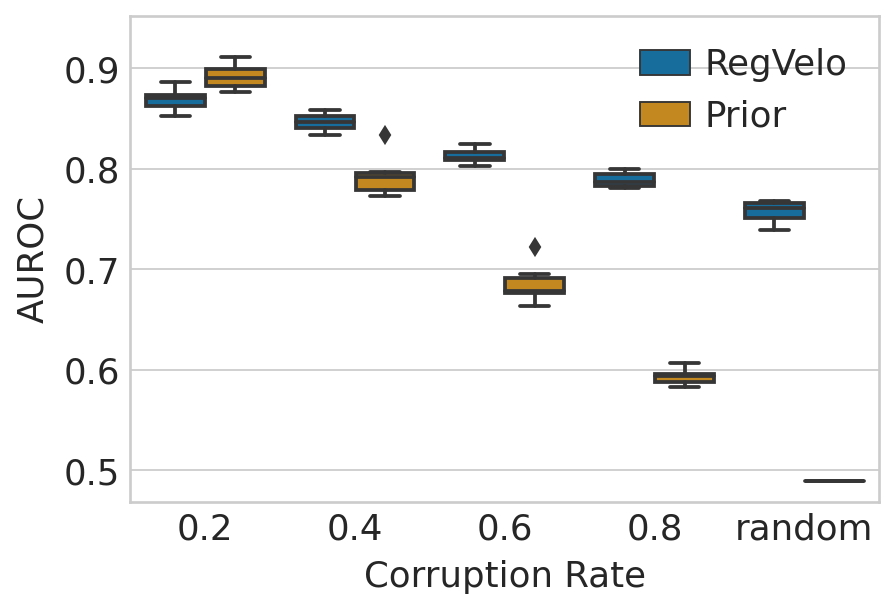

In [39]:
## compare boxplot
with mplscience.style_context():
    sns.set_style(style="whitegrid")
    fig, ax = plt.subplots(figsize=(6, 4))

    sns.boxplot(data=df_auc2, x="Noise Level", y="AUROC", hue="GRN", ax=ax, palette="colorblind")

    plt.xlabel("Corruption Rate", fontsize=16)
    plt.ylabel("AUROC", fontsize=16)

    # Enlarge the numbers on the axes
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    # ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    plt.legend(title="", fontsize=16)
    y_min, y_max = ax.get_ylim()
    ax.set_ylim([y_min, y_max + 0.02])
    # ax.set_xticklabels(ax.get_xticklabels(), rotation=30)

    if SAVE_FIGURES:
        fig.savefig(
            FIG_DIR / "simulation" / "prior_benchmark" / "AUROC_prior_graph.svg",
            format="svg",
            transparent=True,
            bbox_inches="tight",
        )

In [40]:
cor = cor_all[0] + cor_all[1] + cor_all[2] + cor_all[3] + cor_all[4]
Model = (
    ["0.2"] * len(cor_all[0])
    + ["0.4"] * len(cor_all[0])
    + ["0.6"] * len(cor_all[0])
    + ["0.8"] * len(cor_all[0])
    + ["random"] * len(cor_all[0])
)
df2 = pd.DataFrame({"Noise Level": Model, "Correlation": cor})

cor = cor_all_velo[0] + cor_all_velo[1] + cor_all_velo[2] + cor_all_velo[3] + cor_all_velo[4]
noise_level = (
    ["0.2"] * len(cor_all_velo[0])
    + ["0.4"] * len(cor_all_velo[0])
    + ["0.6"] * len(cor_all_velo[0])
    + ["0.8"] * len(cor_all_velo[0])
    + ["random"] * len(cor_all_velo[0])
)
df_velo = pd.DataFrame({"Noise Level": noise_level, "Correlation": cor})

cor = cor_all_time[0] + cor_all_time[1] + cor_all_time[2] + cor_all_time[3] + cor_all_time[4]
noise_level = (
    ["0.2"] * len(cor_all_time[0])
    + ["0.4"] * len(cor_all_time[0])
    + ["0.6"] * len(cor_all_time[0])
    + ["0.8"] * len(cor_all_time[0])
    + ["random"] * len(cor_all_time[0])
)
df_time = pd.DataFrame({"Noise Level": noise_level, "Correlation": cor})

In [41]:
df_all = pd.concat([df2, df_velo, df_time], ignore_index=True)
df_all.loc[:, "Type"] = ["GRN"] * df2.shape[0] + ["Velocity"] * df_velo.shape[0] + ["Latent Time"] * df_time.shape[0]
df_all

,Noise Level,Correlation,Type
0,0.2,0.919614,GRN
1,0.2,0.926529,GRN
2,0.2,0.932747,GRN
3,0.2,0.912684,GRN
4,0.2,0.928602,GRN
...,...,...,...
220,random,0.978902,Latent Time
221,random,0.980413,Latent Time
222,random,0.972021,Latent Time
223,random,0.974526,Latent Time


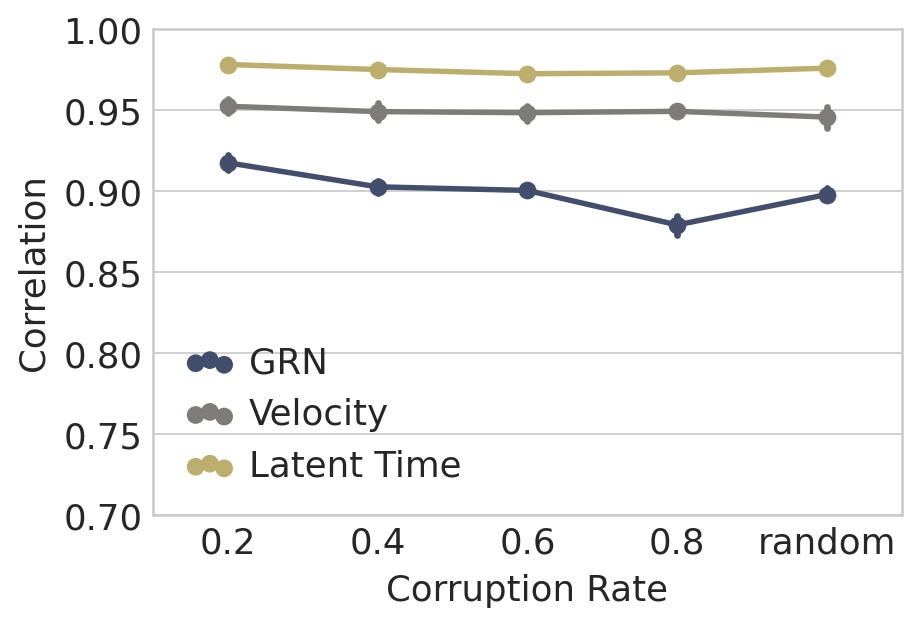

In [42]:
with mplscience.style_context():
    sns.set_style(style="whitegrid")
    fig, ax = plt.subplots(figsize=(6, 4))

    sns.pointplot(data=df_all, x="Noise Level", y="Correlation", hue="Type", ax=ax, palette="cividis", scale=0.8)

    plt.xlabel("Corruption Rate", fontsize=16)
    plt.ylabel("Correlation", fontsize=16)

    # Enlarge the numbers on the axes
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    # ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    plt.legend(title="", fontsize=16)
    # y_min, y_max = ax.get_ylim()
    ax.set_ylim([0.7, 1])
    # ax.set_xticklabels(ax.get_xticklabels(), rotation=30)

    if SAVE_FIGURES:
        fig.savefig(
            FIG_DIR / "simulation" / "prior_benchmark" / "Identifiability_benchmark.svg",
            format="svg",
            transparent=True,
            bbox_inches="tight",
        )

In [43]:
velovi_corr_all = [
    np.mean(velovi_corr1),
    np.mean(velovi_corr2),
    np.mean(velovi_corr3),
    np.mean(velovi_corr4),
    np.mean(velovi_corr5),
    np.mean(velovi_corr6),
]
cor = (
    cor_all_velo_gt[0]
    + cor_all_velo_gt[1]
    + cor_all_velo_gt[2]
    + cor_all_velo_gt[3]
    + cor_all_velo_gt[4]
    + velovi_corr_all
)
Model = ["0.2"] * 6 + ["0.4"] * 6 + ["0.6"] * 6 + ["0.8"] * 6 + ["random"] * 6 + ["veloVI"] * 6
df_velo_gt = pd.DataFrame({"Model": Model, "Correlation": cor})

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


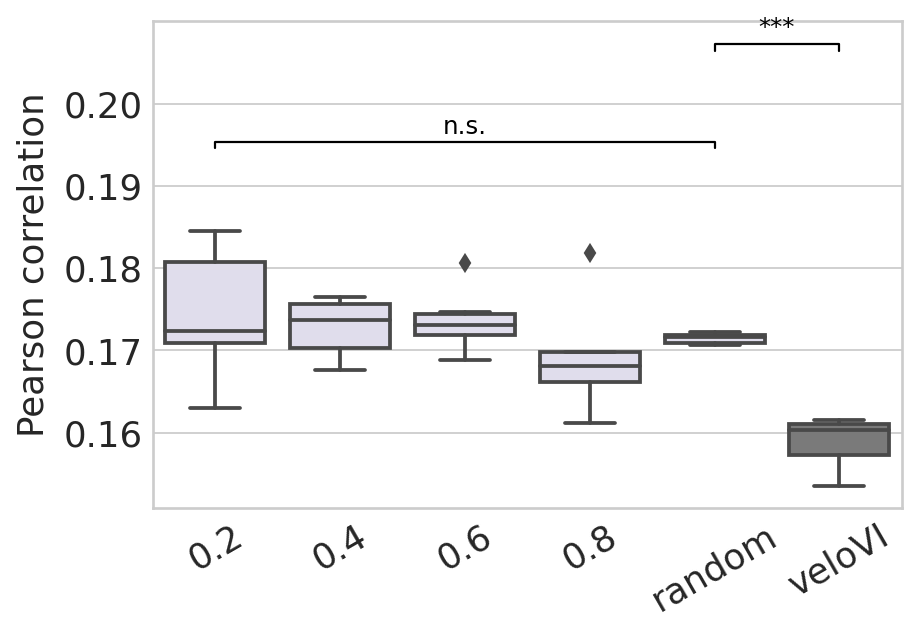

In [45]:
with mplscience.style_context():
    sns.set_style(style="whitegrid")
    fig, ax = plt.subplots(figsize=(6, 4))

    cool_blue = "#DEDBEE"
    warm_orange = "#7A7A7ADD"

    # Create a custom color palette
    custom_palette = [cool_blue] * 5 + [warm_orange]
    sns.boxplot(data=df_velo_gt, x="Model", y="Correlation", ax=ax, palette=custom_palette)

    ttest_res = ttest_ind(
        df_velo_gt.iloc[:, 1][df_velo_gt.iloc[:, 0] == "0.2"].values,
        df_velo_gt.iloc[:, 1][df_velo_gt.iloc[:, 0] == "random"].values,
        alternative="greater",
    )
    significance = get_significance(ttest_res.pvalue)
    add_significance(
        ax=ax,
        left=0,
        right=4,
        significance=significance,
        lw=1,
        bracket_level=1.05,
        c="k",
        level=0,
    )

    ttest_res = ttest_ind(
        df_velo_gt.iloc[:, 1][df_velo_gt.iloc[:, 0] == "random"].values,
        df_velo_gt.iloc[:, 1][df_velo_gt.iloc[:, 0] == "veloVI"].values,
        alternative="greater",
    )
    significance = get_significance(ttest_res.pvalue)
    add_significance(
        ax=ax,
        left=4,
        right=5,
        significance=significance,
        lw=1,
        bracket_level=1.05,
        c="k",
        level=0,
    )

    plt.xlabel("")
    plt.ylabel("Pearson correlation", fontsize=16)

    # Enlarge the numbers on the axes
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    # ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    plt.legend(title="", fontsize=16)
    y_min, y_max = ax.get_ylim()
    ax.set_ylim([y_min, y_max])
    ax.set_xticklabels(ax.get_xticklabels(), rotation=30)

    if SAVE_FIGURES:
        fig.savefig(
            FIG_DIR / "simulation" / "prior_benchmark" / "velocity_prediction.svg",
            format="svg",
            transparent=True,
            bbox_inches="tight",
        )

In [46]:
velovi_corr_time_all = [
    np.mean(corr_velovi_time1),
    np.mean(corr_velovi_time2),
    np.mean(corr_velovi_time3),
    np.mean(corr_velovi_time4),
    np.mean(corr_velovi_time5),
    np.mean(corr_velovi_time6),
]
cor = (
    cor_all_time_gt[0]
    + cor_all_time_gt[1]
    + cor_all_time_gt[2]
    + cor_all_time_gt[3]
    + cor_all_time_gt[4]
    + velovi_corr_time_all
)
Model = ["0.2"] * 6 + ["0.4"] * 6 + ["0.6"] * 6 + ["0.8"] * 6 + ["random"] * 6 + ["veloVI"] * 6
df_time_gt = pd.DataFrame({"Model": Model, "Correlation": cor})

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


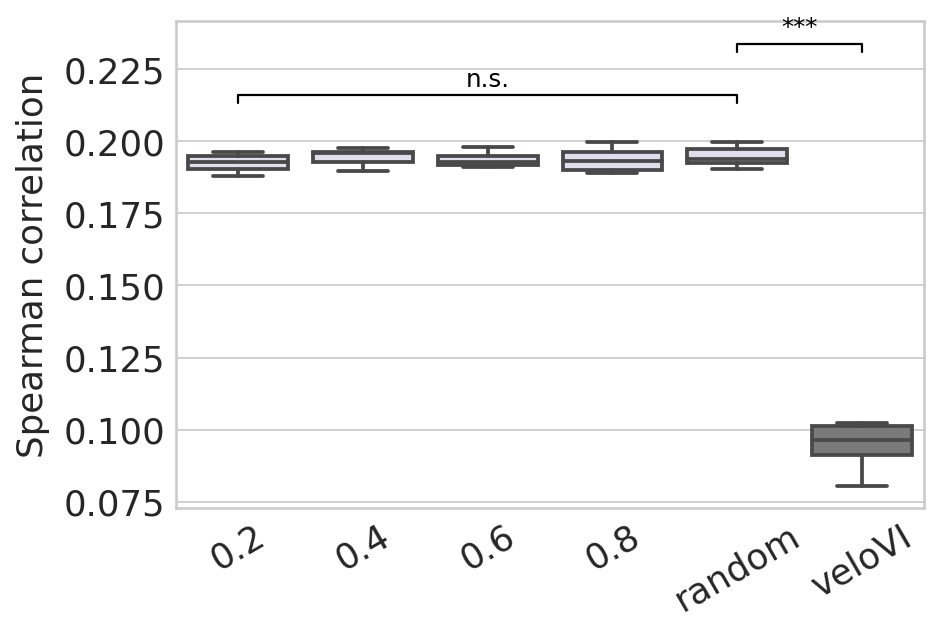

In [47]:
with mplscience.style_context():
    sns.set_style(style="whitegrid")
    fig, ax = plt.subplots(figsize=(6, 4))

    cool_blue = "#DEDBEE"
    warm_orange = "#7A7A7ADD"

    # Create a custom color palette
    custom_palette = [cool_blue] * 5 + [warm_orange]
    sns.boxplot(data=df_time_gt, x="Model", y="Correlation", ax=ax, palette=custom_palette)

    ttest_res = ttest_ind(
        df_time_gt.iloc[:, 1][df_time_gt.iloc[:, 0] == "0.2"].values,
        df_time_gt.iloc[:, 1][df_time_gt.iloc[:, 0] == "random"].values,
        alternative="greater",
    )
    significance = get_significance(ttest_res.pvalue)
    add_significance(
        ax=ax,
        left=0,
        right=4,
        significance=significance,
        lw=1,
        bracket_level=1.05,
        c="k",
        level=0,
    )

    ttest_res = ttest_ind(
        df_time_gt.iloc[:, 1][df_time_gt.iloc[:, 0] == "random"].values,
        df_time_gt.iloc[:, 1][df_time_gt.iloc[:, 0] == "veloVI"].values,
        alternative="greater",
    )
    significance = get_significance(ttest_res.pvalue)
    add_significance(
        ax=ax,
        left=4,
        right=5,
        significance=significance,
        lw=1,
        bracket_level=1.05,
        c="k",
        level=0,
    )

    plt.xlabel("")
    plt.ylabel("Spearman correlation", fontsize=16)

    # Enlarge the numbers on the axes
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    # ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    plt.legend(title="", fontsize=16)
    y_min, y_max = ax.get_ylim()
    ax.set_ylim([y_min, y_max])
    ax.set_xticklabels(ax.get_xticklabels(), rotation=30)

    if SAVE_FIGURES:
        fig.savefig(
            FIG_DIR / "simulation" / "prior_benchmark" / "latent_time_prediction.svg",
            format="svg",
            transparent=True,
            bbox_inches="tight",
        )